## Imports

In [772]:
import numpy as np
import einops
import matplotlib
import matplotlib.pyplot as plt


from scipy.spatial import ckdtree
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

from shapely.geometry.polygon import Polygon
import shapely
from shapely import affinity

import importlib

In [748]:
import bonds
import lattice
import utils
import plot_utils

In [749]:
bonds = importlib.reload(bonds)
lattice = importlib.reload(lattice)
utils = importlib.reload(utils)


## Set up lattice

### WIP distance nearest neighbours


x shape: (5, 6)
(30, 2)
[[0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]]


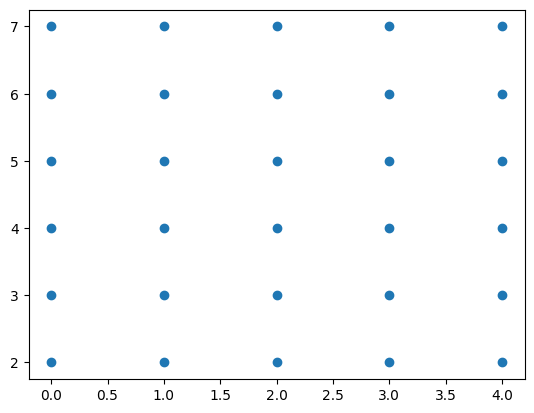

In [ ]:
import numpy as np
import sklearn
from scipy.spatial import KDTree
# from sklearn.neighbors import KDTree
x, y = np.mgrid[0:5, 2:8]
coords = np.c_[x.ravel(), y.ravel()]
print(f"x shape: {x.shape}")

tree = KDTree(np.c_[x.ravel(), y.ravel()])
print(np.c_[x.ravel(), y.ravel()].shape)
print(coords[:5, :])
plt.scatter(x, y)

In [ ]:
from scipy.spatial.distance import pdist
import scipy
d = pdist(coords)
d_mat = scipy.spatial.distance.squareform(d)
k = ((d<1.5) & (0.<d)).nonzero()[0]
print(f"d is {d.shape} and k is {k.shape}")
print(f"d mat shape is {d_mat.shape}")
k_tup = ((d_mat<1.5) & (0.<d_mat)).nonzero()
k_mat = np.stack(k_tup, axis=1)
print(k_mat.shape)

d is (435,) and k is (89,)
d mat shape is (30, 30)
(178, 2)


In [ ]:
dd, ii = tree.query([[1, 2]], k=2)
print(dd, ii, sep='\n')
print(coords[ii, :])

[[0. 1.]]
[[6 0]]
[[[1 2]
  [0 2]]]


In [ ]:
nearest_dist, nearest_ind = tree.query(coords[:4], k=9, eps=1e5)  # k=2 nearest neighbors where k1 = identity
#  print(X)
print(nearest_dist[:, :])    # drop id; assumes sorted -> see args!
print(nearest_ind[:, 1])     # drop id 
print(f"the pair of points that are closest to each other are:\n {coords[:4]}\n")
print(f"and\n {coords[nearest_ind[:, 1], :]}")

[[0.         1.         1.         1.41421356 2.         2.
  2.23606798 2.23606798 2.82842712]
 [0.         1.         1.         1.         1.41421356 1.41421356
  2.         2.         2.23606798]
 [0.         1.         1.         1.         1.41421356 1.41421356
  2.         2.         2.        ]
 [0.         1.         1.         1.         1.41421356 1.41421356
  2.         2.         2.        ]]
[1 2 3 2]
the pair of points that are closest to each other are:
 [[0 2]
 [0 3]
 [0 4]
 [0 5]]

and
 [[0 3]
 [0 4]
 [0 5]
 [0 4]]


In [ ]:
nearest_dist, nearest_ind = tree.query(coords, k=2)  # k=2 nearest neighbors where k1 = identity
#  print(X)
print(nearest_dist[:, 1])    # drop id; assumes sorted -> see args!
print(nearest_ind[:, 1])     # drop id a

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
[ 1  0  1  2  3  4  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23]


### Triangular

In [750]:
# # lattice params for kagome lattice
# nx = 4
# ny = 3
# grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
#                'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 
#                'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
#                                  }
# mesh = lattice.create_grid_mesh(grid_params)
# BZ_kpoints = lattice.create_grid(grid_params)
# my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

In [751]:
# lattice params for triangular lattice
nx = 8
ny = 8
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0.,0.), 
               'unit_cell_bases':[np.array([0.,0.])] 
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

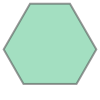

In [752]:
# Define the polygon for the cut
height = np.sqrt(3)/2
epsilon = 0.01 # to shift the boundary of the polygon slightly so that the region counts correct points within the boundary
polygon = Polygon([(3 - epsilon, 0 - epsilon), (7 + epsilon, 0 - epsilon), (8.5 + epsilon, 3 * height + epsilon), 
                   (6.5 + epsilon, 7 * height + epsilon), (3.5 - epsilon, 7 * height + epsilon), (1.5 - epsilon, 3 * height + epsilon)])
polygon

In [753]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

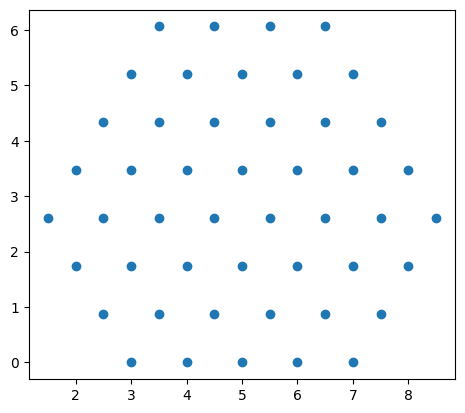

In [754]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=48 and $N_{\\rm bonds}=$120')

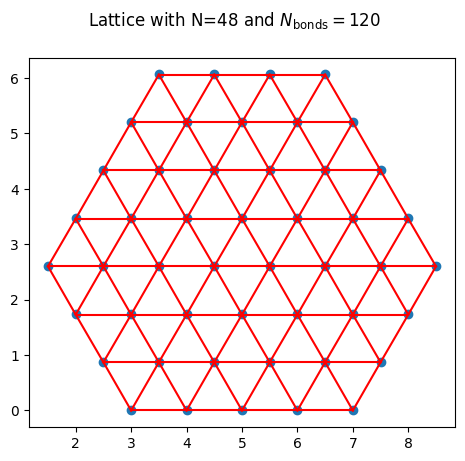

In [755]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [756]:
ListEB_comb = bonds.get_elementaryLoops((8, 8), 'triangular')
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

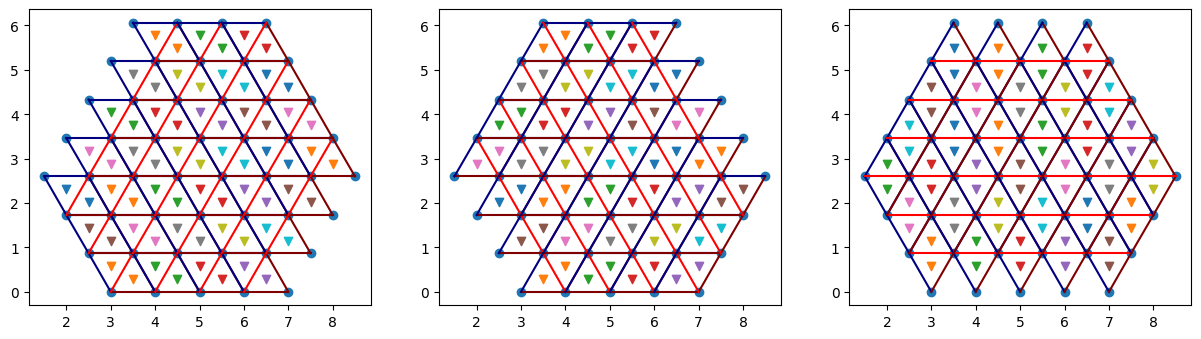

In [757]:
fig, axes = plt.subplots(1,3, figsize = (3 * 5, 5))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
    plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

### Kagome

In [758]:
# lattice params for kagome lattice
nx = 6
ny = 6
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 'O':(0., 0.),
               'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

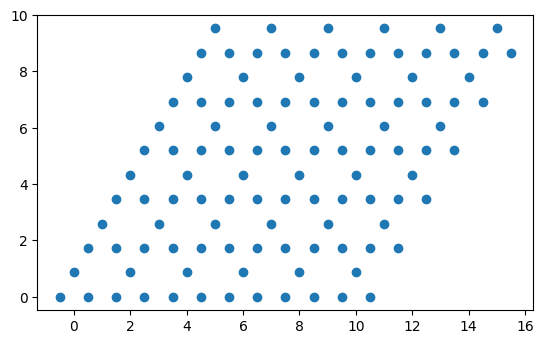

In [759]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

In [760]:
height = np.sqrt(3)/2
polygon = lattice.create_hexagon(5.1, 7, 5 * height)
LatticeSpecs = lattice.Lattice(
    a1=np.array([2,0]),
    a2=np.array([1, np.sqrt(3)]),
    unit_cell_bases=[np.array([0.0, 0.0])], 
    lattice_type='kagome', 
    polygon=polygon, 
)

ebSpecs = bonds.Bonds(
    polygon_ebs = [
        affinity.scale(affinity.translate(polygon, xoff=0., yoff=height +0.2), xfact=0.9, yfact=0.85), 
        affinity.translate(affinity.scale(polygon, xfact=0.85, yfact=0.85), xoff=1.2, yoff=height -0.1),
        affinity.scale(affinity.translate(polygon, xoff=0.8, yoff=-0.5), xfact=0.95, yfact=0.9), 
        affinity.scale(affinity.translate(polygon, xoff=0.0, yoff=-0.6), xfact=1., yfact=0.9), 
        affinity.scale(affinity.translate(polygon, xoff=-0.6, yoff=-0.5), xfact=0.95, yfact=0.9), 
        affinity.scale(affinity.translate(polygon, xoff=-0.6, yoff=0.5), xfact=0.95, yfact=0.9), 
    ], 
    unit_cell_bases_ebs = [
        np.array([0, height]), 
        np.array([1.5, 0.]),
        np.array([0.5, 0.]),
        np.array([0., height]),
        np.array([-0.5, 0.]),
        np.array([0.5, 0.]),
    ]    
)

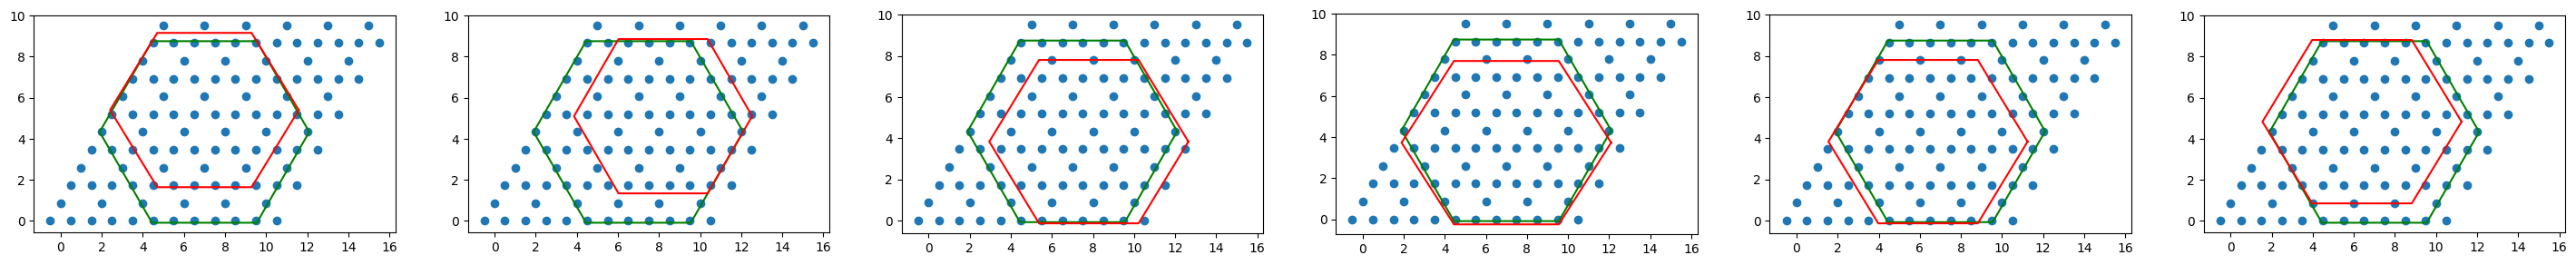

In [761]:

fig, axes = plt.subplots(1,6, figsize=(6 *6, 8))
for i, ax in enumerate(axes):
    ax = axes[i]
    my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
    ax.scatter(my_x, my_y)
    ax.set_aspect("equal")
    x,y = polygon.exterior.xy
    polygon2 = ebSpecs.polygon_ebs[i]
    x2,y2 = polygon2.exterior.xy
    ax.plot(x,y, c='g', label="cut boundary")
    ax.plot(x2,y2, c='r', label="cut boundary")

In [762]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

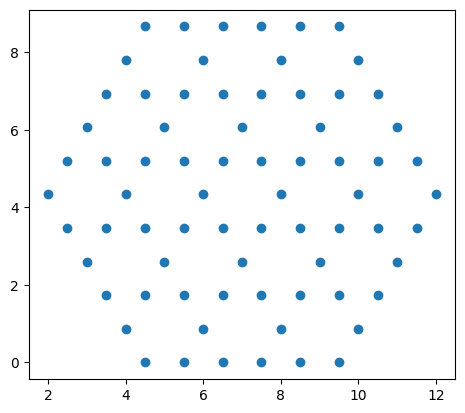

In [763]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=72 and $N_{\\rm bonds}=$126')

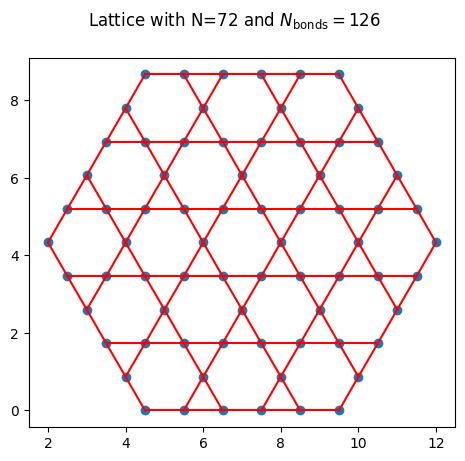

In [764]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [765]:
ListEB_comb = bonds.get_elementaryLoops((nx, ny), 'na', LatticeSpecs, ebSpecs)
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

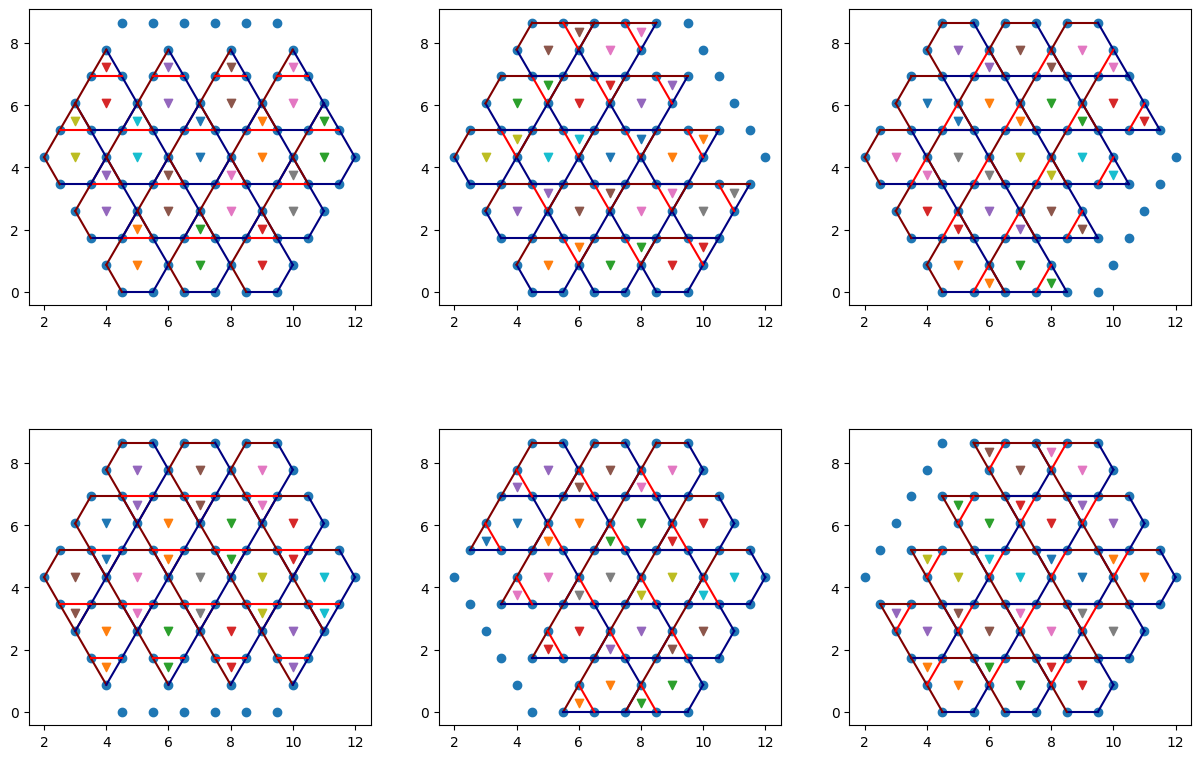

In [766]:
fig, axes = plt.subplots(2,3, figsize = (3 * 5, 5 * 2))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i // 3, i % 3]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
    plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

### Saddle point 

In [784]:
bonds_dict = utils.build_dict_bonds(bonds_nn)

In [785]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(len(bonds_nn))
Q0 = 1.
energy_Q = lambda Q_init: utils.get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)

In [786]:
# Q0 = 0.0001
results_gs = minimize(energy_Q, Q_init)

In [787]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-33.39654680773622
True
Optimization terminated successfully.
0


array([0.7529864 , 0.75298668, 0.75058837, 0.77769425, 0.77490905,
       0.75150099, 0.74987231, 0.75196405, 0.73273009, 0.66342021,
       0.73393724, 0.76986154, 0.77814243, 0.68236473, 0.7722565 ,
       0.79398601, 0.78089407, 0.71734331, 0.7777559 , 0.76790781,
       0.76502215, 0.71303574, 0.75323619, 0.75405052, 0.66342063,
       0.75298647, 0.75590002, 0.77663472, 0.65920532, 0.77225667,
       0.77880992, 0.78075792, 0.69132581, 0.77818724, 0.77685775,
       0.77727488, 0.69462512, 0.77469557, 0.75001228, 0.74528913,
       0.69421707, 0.734958  , 0.75615165, 0.79482934, 0.68236494,
       0.77490893, 0.77977805, 0.77913249, 0.69132579, 0.77775546,
       0.77826174, 0.77670844, 0.69218273, 0.77469558, 0.77189511,
       0.7537365 , 0.69878952, 0.75343163, 0.71304872, 0.71122529,
       0.74318552, 0.77589747, 0.77085008, 0.71734352, 0.75196446,
       0.77296704, 0.75348439, 0.69462457, 0.7532364 , 0.76804943,
       0.73411601, 0.69878923, 0.73495757, 0.72939242, 0.73100

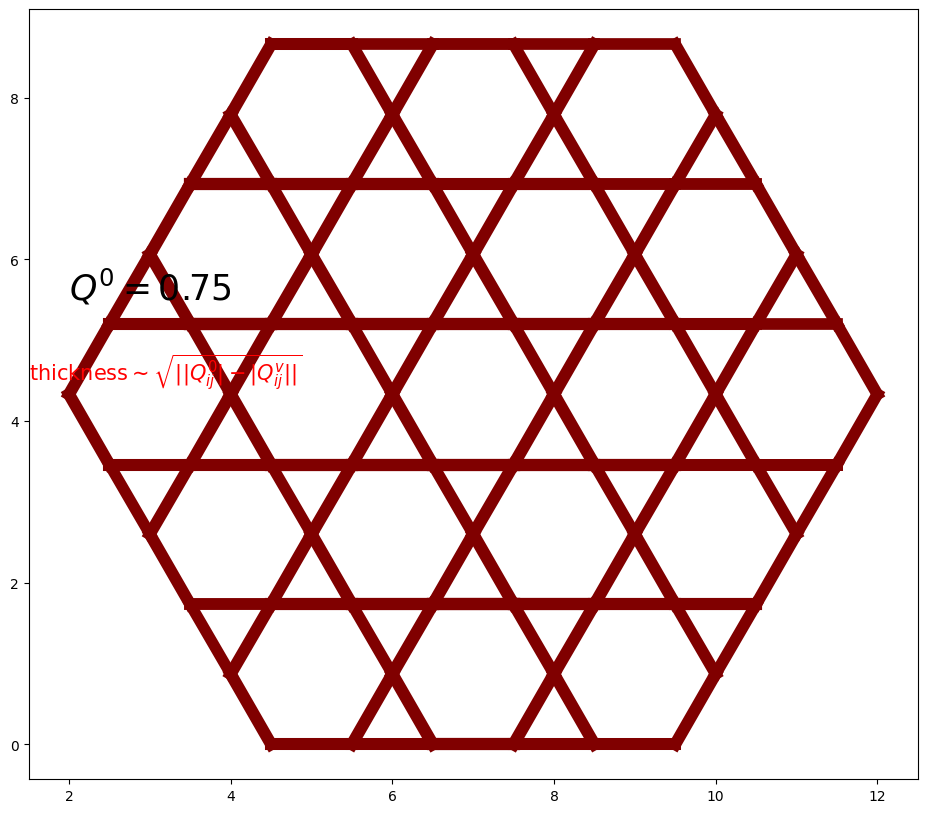

In [788]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_init), Q_init * results_gs['x'], c=colors[((np.sign(results_gs['x']) + 1)/2).astype(int)], p=10)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{||Q^0_{ij}| - |Q^v_{ij}||}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

In [789]:
visonBonds_vs = [np.array([[7.5, 4 * height], [8., 5 * height]]),
                 np.array([[7.5, 4 * height], [8.5, 4. * height]]), 
              np.array([[8.5, 4. * height], [9.,  3 * height]]), 
              np.array([[9.,  3 * height], [9.5, 4 *height]]), 
              np.array([[10.5, 2 *height], [11, 3 * height]]),
              ]
visonBonds_idx = []
Q_flip = Q_init
for bd_v in visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[bd_v.tobytes()]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

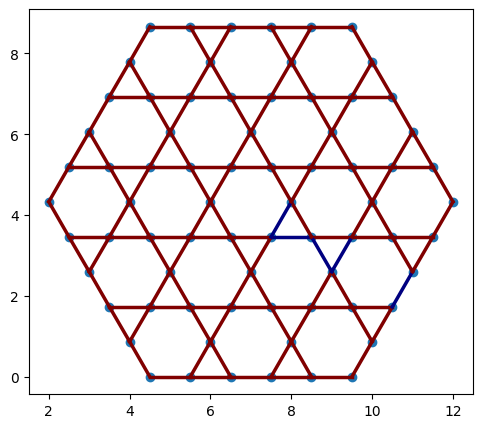

In [790]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
Q_flip = Q_init
# print(Q_init)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
  plt.suptitle("visualizing branch cut")

### vison


In [791]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = results_gs['x'] 
Q0 = 1.
for idx in visonBonds_idx:
  Q_init[idx] = -1 * Q_init[idx]
energy_Q = lambda Q_init: utils.get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init), 5* np.ones_like(Q_init))
results_vison = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

/Users/Yanting/Repositories/rydberg-vison/venv/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 130, function evaluations: 24638, CG iterations: 2097, optimality: 5.23e-07, constraint violation: 0.00e+00, execution time: 9e+01 s.


In [792]:
energy_Q(Q_init)

-33.035022141570934

In [793]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-33.16664592490777
True
`xtol` termination condition is satisfied.
2


array([ 0.75265669,  0.75265671,  0.75053722,  0.77765326,  0.77485762,
        0.75148843,  0.74987675,  0.75195907,  0.73211186,  0.66355968,
        0.73333307,  0.76942347,  0.77314929,  0.68251261,  0.76711317,
        0.79369454,  0.78111085,  0.71747484,  0.77816678,  0.76771822,
        0.76497185,  0.71307172,  0.75305204,  0.75373085,  0.66355968,
        0.7526567 ,  0.7552232 ,  0.77147918,  0.65959422,  0.76711314,
        0.74368576,  0.65874228,  0.73356462,  0.74213544, -0.74579252,
        0.77113975, -0.69843737,  0.74135633,  0.74779268,  0.74514495,
        0.69434102,  0.73267724,  0.7558378 ,  0.79464934,  0.68251261,
        0.77485762,  0.77470661,  0.79928921,  0.73356461,  0.77816676,
        0.74007224,  0.7375666 ,  0.64633001,  0.74135632,  0.76711306,
        0.75107809,  0.69557123,  0.74901151,  0.71286659,  0.7111956 ,
        0.74283218,  0.77586506,  0.77098688,  0.71747479,  0.75195908,
        0.77349428,  0.75459989,  0.69843738,  0.75305204,  0.76

In [794]:
Q0_results = results_gs['x']
Qv_results = results_vison['x']

Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

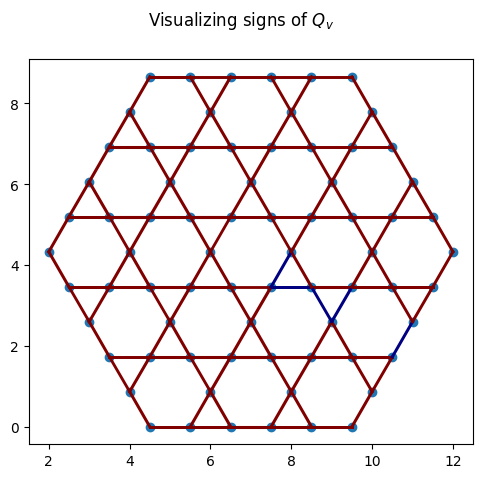

In [796]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [797]:
Qv_results - Q0_results

array([-3.29705671e-04, -3.29965980e-04, -5.11546211e-05, -4.09885059e-05,
       -5.14238063e-05, -1.25599436e-05,  4.44193428e-06, -4.98611638e-06,
       -6.18230899e-04,  1.39473272e-04, -6.04172331e-04, -4.38077628e-04,
       -4.99314071e-03,  1.47879556e-04, -5.14332786e-03, -2.91466575e-04,
        2.16774607e-04,  1.31528863e-04,  4.10885490e-04, -1.89589982e-04,
       -5.02955038e-05,  3.59792642e-05, -1.84149167e-04, -3.19676277e-04,
        1.39056349e-04, -3.29774316e-04, -6.76818980e-04, -5.15553735e-03,
        3.88900347e-04, -5.14353351e-03, -3.51241666e-02, -1.22015637e-01,
        4.22388134e-02, -3.60518061e-02,  3.10652317e-02, -6.13512720e-03,
       -3.81225308e-03, -3.33392443e-02, -2.21959053e-03, -1.44182234e-04,
        1.23949365e-04, -2.28076204e-03, -3.13842080e-04, -1.80003888e-04,
        1.47669124e-04, -5.13143443e-05, -5.07144209e-03,  2.01567183e-02,
        4.22388170e-02,  4.11306619e-04, -3.81894978e-02, -3.91418389e-02,
       -4.58527227e-02, -

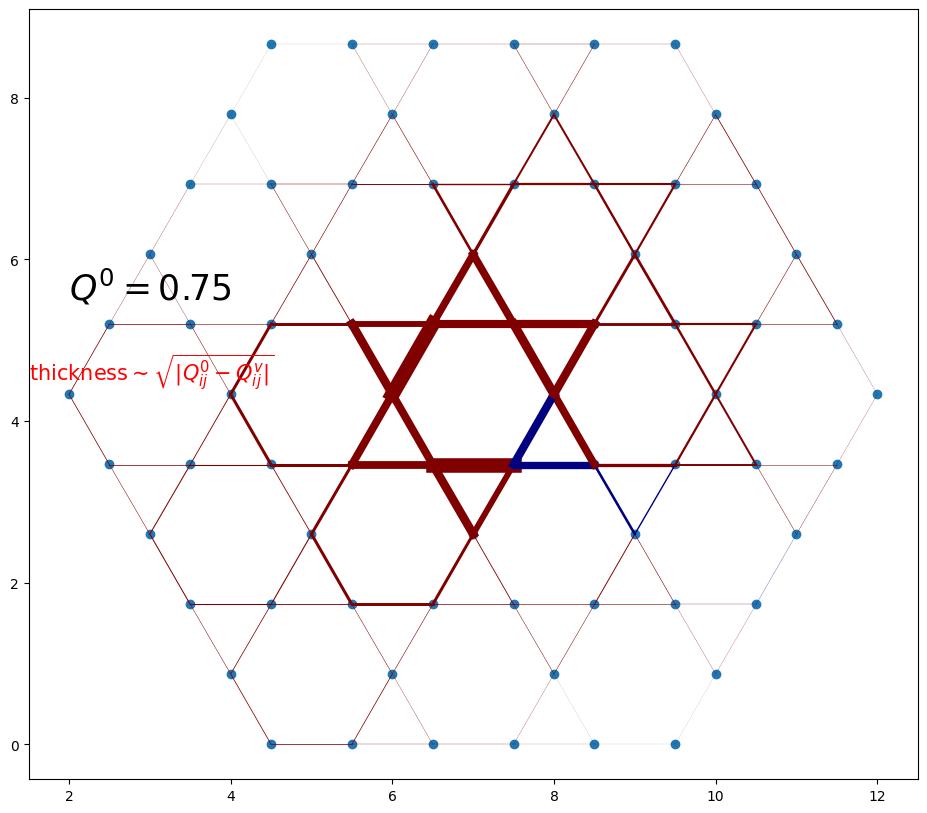

In [801]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, Q0_results,  Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{|Q^0_{ij} - Q^v_{ij}|}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')